## Imports

In [207]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

## Preprocessing & split validation set

In [208]:
# Split the 'valid_time' into date and time
def extract_datetime_features(df):
    df['valid_time'] = pd.to_datetime(df['valid_time']) # Transfer 'valid_time' into datetime type
    df['year'] = df['valid_time'].dt.year
    df['month'] = df['valid_time'].dt.month
    df['day'] = df['valid_time'].dt.day
    df['hour'] = df['valid_time'].dt.hour
    df['weekday'] = df['valid_time'].dt.weekday
    return df

In [209]:
# Add nearby features
def add_lag_features(df, features, group_cols=['latitude', 'longitude'], lag=1):
    df = df.sort_values(by=group_cols + ['valid_time']).reset_index(drop=True)
    for feat in features:
        df[f'{feat}_lag{lag}'] = df.groupby(group_cols)[feat].shift(lag)
    return df

def add_spatial_averages(df, features, lat_step=0.25, lon_step=0.25):
    avg_features = []
    for feat in features:
        df_list = []
        for dlat in [-lat_step, 0, lat_step]:
            for dlon in [-lon_step, 0, lon_step]:
                shifted = df[['latitude', 'longitude', 'valid_time', feat]].copy()
                shifted['latitude'] += dlat
                shifted['longitude'] += dlon
                shifted = shifted.rename(columns={feat: f'{feat}_shift_{dlat}_{dlon}'})
                df_list.append(shifted)
        for df_part in df_list:
            df = df.merge(df_part, on=['latitude', 'longitude', 'valid_time'], how='left')
        mean_cols = [f'{feat}_shift_{dlat}_{dlon}' for dlat in [-lat_step, 0, lat_step] for dlon in [-lon_step, 0, lon_step]]
        df[f'{feat}_spatial_mean'] = df[mean_cols].mean(axis=1)
        df = df.drop(columns=mean_cols)
        avg_features.append(f'{feat}_spatial_mean')
    return df


In [210]:
df = pd.read_csv('/cs/datasets/ID5059/Coursework2/data/train.csv')
df = extract_datetime_features(df)

# Ensure time order
df_sampled = df.iloc[:50000]
split_idx = int(len(df_sampled) * 0.8)
train_df = df_sampled.iloc[:split_idx]
val_df = df_sampled.iloc[split_idx:]

In [211]:
# Add time lag
time_lag_vars = ['tp', 'sp', 'u10', 'v10']
train_df = add_lag_features(train_df, time_lag_vars)
val_df = add_lag_features(val_df, time_lag_vars)

# Add nearby spatial features
spatial_vars = ['tp', 'sp', 'tcc']
train_df = add_spatial_averages(train_df, spatial_vars)
val_df = add_spatial_averages(val_df, spatial_vars)

# Add lagging spatial average
spatial_lag_vars = [f'{var}_lag1' for var in time_lag_vars]
train_df = add_spatial_averages(train_df, spatial_lag_vars)
val_df = add_spatial_averages(val_df, spatial_lag_vars)

# Drop N/A
train_df = train_df.dropna()
val_df = val_df.dropna()


In [212]:
# Construct the feature list
base_vars = ['tp', 'sp', 'u10', 'v10']
time_lag_vars = [f'{var}_lag1' for var in base_vars]
spatial_vars = ['tp', 'sp', 'tcc']
spatial_lag_vars = [f'{var}_lag1' for var in base_vars]
time_cols = ['month', 'day', 'hour', 'weekday']

feature_cols = base_vars + time_lag_vars + spatial_vars + spatial_lag_vars + time_cols

# Make X/y using the feature list
X_train = train_df[feature_cols]
y_train = train_df['t2m']
X_val = val_df[feature_cols]
y_val = val_df['t2m']


## Model Training

In [213]:
# Train the model
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1)
model.fit(X_train, y_train)

# Make the prediction using validation set
y_pred_val = model.predict(X_val)

# Evaluation
mse = mean_squared_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

MSE: 2.0400
R²: 0.6919



## Feature importances

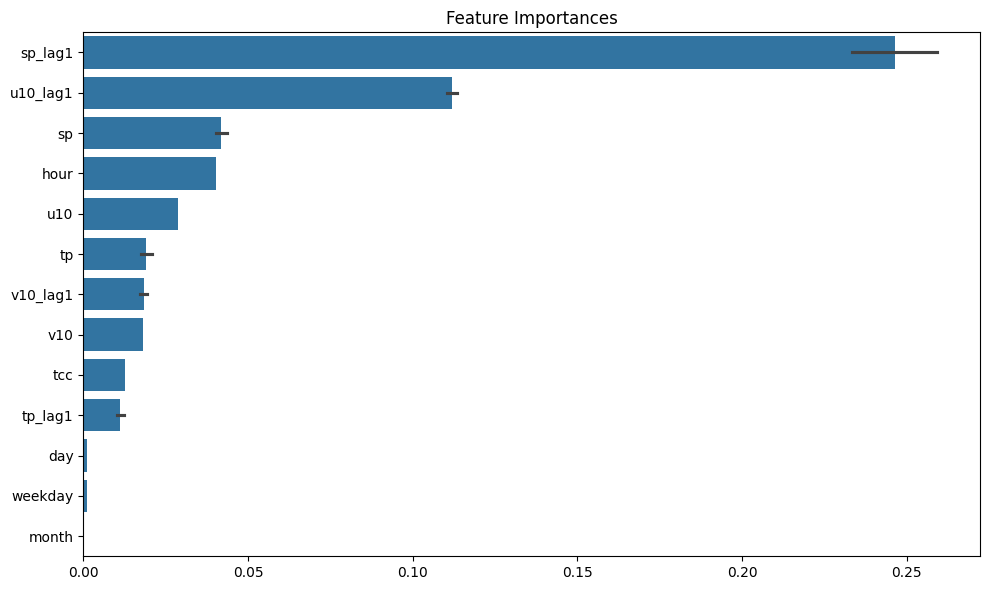

In [214]:
features = np.array(X_train.columns)  # In case a 'None' shown on the y
importances = model.feature_importances_

# Show from the highest ranking
sorted_idx = importances.argsort()[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[sorted_idx], y=features[sorted_idx])
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


## Save the model

In [215]:
joblib.dump(model, 'randomForest.pkl')

['randomForest.pkl']

## Make prediction using test set

In [216]:
# Read and process test set
test_df = pd.read_csv('/cs/datasets/ID5059/Coursework2/data/test.csv')
test_df = extract_datetime_features(test_df)
subset = test_df[(test_df['latitude'] == 56.25) & (test_df['longitude'] == -2.75)].copy()

In [217]:

# Construct the lagging features as in training
subset = add_lag_features(subset, base_vars, group_cols=['latitude', 'longitude'])
subset = add_spatial_averages(subset, spatial_vars)
subset = add_spatial_averages(subset, spatial_lag_vars)
subset = subset.dropna()

# Only select the data required
X_test = subset[feature_cols]  # Ensure that the features are the same

# Load the model and predict
model = joblib.load('randomForest.pkl')
y_pred_test = model.predict(X_test)

# Save the predicting result
submission = pd.DataFrame({
    'valid_time': subset['valid_time'],
    'prediction': y_pred_test
}) # Meet the requirement
submission.to_csv('prediction_randomForest.csv', index=False)


## Summary

In [218]:
print("Validation Set Performance:")
print(f"MSE: {mean_squared_error(y_val, model.predict(X_val)):.4f}")
print(f"R² : {r2_score(y_val, model.predict(X_val)):.4f}")

Validation Set Performance:
MSE: 2.0400
R² : 0.6919


## Fine tuning

In [219]:

# Parameter grid (simple)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Basic model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Grid search
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

# Model training
grid_search.fit(X_train, y_train)

# Print the results
print("Best Parameters:", grid_search.best_params_)
print("Best R² Score on CV:", grid_search.best_score_)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)

mse = mean_squared_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f"\nValidation MSE: {mse:.4f}")
print(f"Validation R²: {r2:.4f}")


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best R² Score on CV: 0.5894607911365348

Validation MSE: 1.6679
Validation R²: 0.7481
